## Laboratorium 13


## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Jednak w praktyce czasami dysponujemy materiałem wideo, a więc sygnałami _trójwymiarowymi_, gdzie trzecim wymiarem jest czas. Oczywiście, można takie dane traktować jako po prostu sekwencję niezależnych obrazów - i wtedy działają wszystkie poznane dotychczas metody. Jednak dlaczego by nie wykorzystać tej dziedziny czasowej do przetwarzania sygnału? Intuicyjnie czujemy, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Najpowszechniejszą metodą do automatycznej detekcji ruchu jest metoda przepływu optycznego (ang. _optical flow_). Pominiemy w tej instrukcji matematyczne podstawy tej metody - te są wystarczająco dobrze wyłożone w [artykule z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), do którego lektury namawiam. Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:
* przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (tym zajmiemy się na przyszłych zajęciach),
* przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela. Na tym podejściu skupimy się w ramach tego laboratorium.

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.

### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując translację pomiędzy jedną a drugą. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną i poprzednią.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu hardware'owego działającego w czasie rzeczywistym). Idea jest prosta:
* tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
* pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:
```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).

Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Zadanie 1 (1.0 pkt | 1.0 pkt)

#### Zadanie 1a (1.0 pkt | 0.0 pkt)
Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.

In [17]:
def get_frame_seq(path, idx, length=2):
    vid = cv2.VideoCapture(path)
    for _ in range(idx - 1):
        vid.read()
    return [cv2.cvtColor(vid.read()[1], cv2.COLOR_BGR2GRAY) for _ in range(length)]

In [18]:
def get_flow(file, frame_idx, winsize=15):
    frames = get_frame_seq(file, frame_idx)
    flow = cv2.calcOpticalFlowFarneback(frames[0], frames[1], None, 0.5, 3, winsize, 3, 5, 1.2, 0)
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    return mag

def show_flow(file, frame_idx, winsize=15):
    mag = get_flow(file, frame_idx, winsize)
    return plt.imshow(mag)

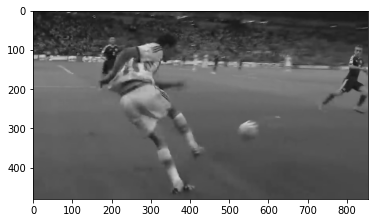

In [19]:
frames = get_frame_seq('dane/back.mp4', 33)
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))

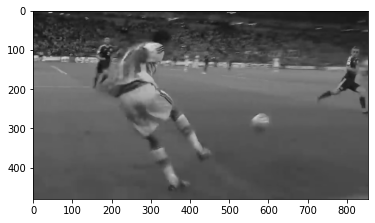

In [20]:
plt.imshow(cv2.cvtColor(frames[1], cv2.COLOR_BGR2RGB))

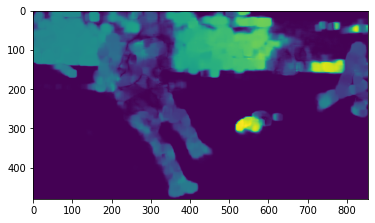

In [21]:
show_flow('dane/back.mp4', 33)

#### Zadanie 1b (0.0 pkt | 1.0 pkt)
Zbadaj wpływ parametru `winsize` na działanie metody.

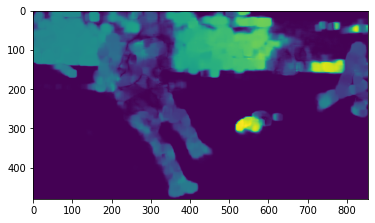

In [22]:
show_flow('dane/back.mp4', 33, 15)

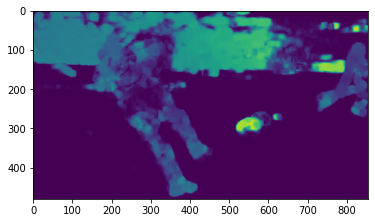

In [23]:
show_flow('dane/back.mp4', 33, 10)

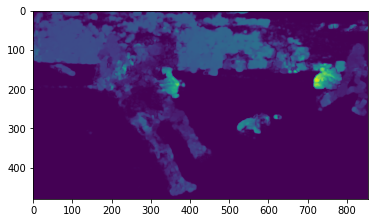

In [24]:
show_flow('dane/back.mp4', 33, 5)

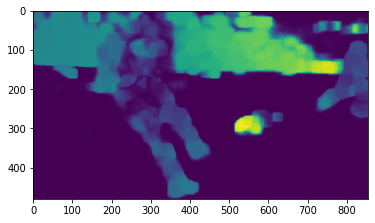

In [25]:
show_flow('dane/back.mp4', 33, 20)

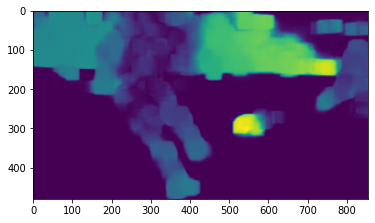

In [26]:
show_flow('dane/back.mp4', 33, 30)

Komentarz 1:

`winsize` decyduje o wielkości okna w którym różnice między pikselami w obu klastkach są uśredniane. W rezultacie im większe okno, tym bardziej rozmyty jest obraz wyjściowy. Zbyt małe okno powoduje, że obraz jest bardzo ziarnisty i zaszumiony. Zbyt duże powoduje, że obiekty tracą swój kształt.

---

### Zadanie 2 (1.0 pkt | 1.0 pkt)

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
*W czym leży trudność? Co jest ograniczeniem metody?*

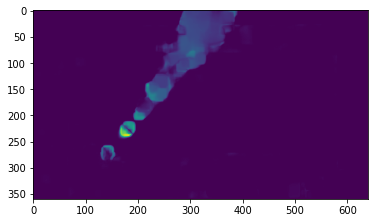

In [27]:
show_flow('dane/shot.mp4', 22)

Komentarz 2:

Problem pojawia się kiedy mamy do czynienia z wideo o niskiej ilości klatek na sekundę. Powoduje to, że ruch jest mało płynny i tak jak na powyższym obrazie obiekty zamiast stopniowo się przesuwać, zachowując w większości swój kształt, "skaczą" przez co wykrywane są w 2 różnych miejscach na raz (tutaj biała bila zostaje wykryta w 2 miejscach).

### Zadanie 3 (1.0 pkt | 0.0 pkt)

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).

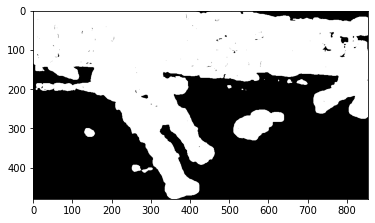

In [61]:
img = get_flow('dane/back.mp4', 33)

img = (img * 255).astype(np.uint8)

kernel_blur = np.ones((3, 3), np.float32) / 9
img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel_blur)

_, result_img = cv2.threshold(img, 15, 255, cv2.THRESH_BINARY_INV)

plt.imshow(result_img, cmap='Greys')

Użycie rozmycia (co może być zastąpione większym oknem w Farneback'u) w połączeniu z binaryzacją thresholdową pozwala w skuteczy sposób oddzielić poruszające się obiekty od statycznego tła.